In [1]:
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
np.set_printoptions(threshold=np.nan)
np.random.seed(117)
modelSaveDir = 'model/'
if not os.path.exists(modelSaveDir):
    os.mkdir(modelSaveDir)

Using TensorFlow backend.


In [2]:
from load_affnist import loadmat
Xtrain = []
ytrain = []
for i in range(1,33):
    mat = loadmat('data/training_and_validation_batches/' + str(i) + '.mat')
    Xtrain.append(mat['affNISTdata']['image'].T)
    ytrain.append(mat['affNISTdata']['label_int'])
X_train = np.vstack(Xtrain)
y_train = np.vstack(ytrain)
y_train = y_train.reshape((y_train.shape[0] * y_train.shape[1],))
testDICT = loadmat('data/test.mat')
X_test = testDICT['affNISTdata']['image'].T
y_test = testDICT['affNISTdata']['label_int']

In [3]:
# label = np.unique(y_test)
X_train = X_train.reshape((X_train.shape[0], 40, 40, 1))
X_test = X_test.reshape((X_test.shape[0], 40, 40, 1))
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1920000, 40, 40, 1), (1920000, 10), (320000, 40, 40, 1), (320000, 10))

In [4]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Input, Flatten
from keras.models import Model, model_from_json

savedModelExist = os.path.exists(modelSaveDir + 'baseline_cnn_model.json') and os.path.exists(modelSaveDir + 'baseline_cnn_model.h5') and False

if not savedModelExist:
    ipt = Input((40, 40, 1))
    x = ipt
    x = Conv2D(filters=512, kernel_size=(9, 9), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(5, 5), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(units=10, activation='softmax')(x)
    model = Model(inputs=ipt, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_json = model.to_json()
    with open(modelSaveDir + "baseline_cnn_model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(modelSaveDir + "baseline_cnn_model.h5")
else:
    json_file = open(modelSaveDir + 'baseline_cnn_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(modelSaveDir + 'baseline_cnn_model.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train on 1920000 samples, validate on 320000 samples
Epoch 1/5
1920000/1920000 [==============================] - 2025s 1ms/step - loss: 0.0663 - acc: 0.9797 - val_loss: 0.0379 - val_acc: 0.9885
Epoch 2/5
1920000/1920000 [==============================] - 1996s 1ms/step - loss: 0.0225 - acc: 0.9933 - val_loss: 0.0306 - val_acc: 0.9912
Epoch 3/5
1920000/1920000 [==============================] - 1989s 1ms/step - loss: 0.0167 - acc: 0.9951 - val_loss: 0.0366 - val_acc: 0.9912
Epoch 4/5
1920000/1920000 [==============================] - 1986s 1ms/step - loss: 0.0142 - acc: 0.9959 - val_loss: 0.0423 - val_acc: 0.9911
Epoch 5/5
1920000/1920000 [==============================] - 1977s 1ms/step - loss: 0.0133 - acc: 0.9963 - val_loss: 0.0411 - val_acc: 0.9916


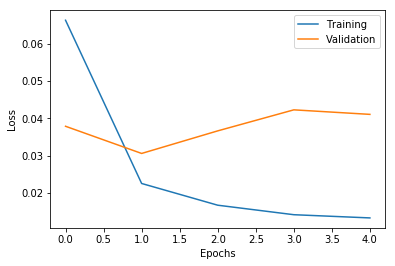

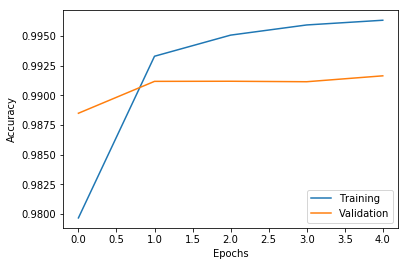

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history['loss'])
    plt.plot(network_history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history['acc'])
    plt.plot(network_history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
import pickle
if not savedModelExist:
    network_history = model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test))
    network_history = network_history.history
    with open(modelSaveDir + 'baseline_cnn_network_history.pkl', 'wb') as f:
        pickle.dump(network_history, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(modelSaveDir + 'baseline_cnn_network_history.pkl', 'rb') as f:
        network_history = pickle.load(f)
plot_history(network_history)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cnn_prfs = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('precision:', cnn_prfs[0], '\nrecall:', cnn_prfs[1], '\nfscore:', cnn_prfs[2])